In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [5]:
file_path = "data\\assignmentSegmentBrainGmmEmMrf.mat"
with h5py.File(file_path, 'r') as mat_file:
    for key in mat_file.keys():
        print(f"Dataset: {key}, Shape: {mat_file[key].shape}")


Dataset: imageData, Shape: (256, 256)
Dataset: imageMask, Shape: (256, 256)


In [7]:
with h5py.File(file_path, 'r') as mat_file:
    data = np.array(mat_file['imageData'])
    mask = np.array(mat_file['imageMask'])

Text(0.5, 1.0, 'imageMask')

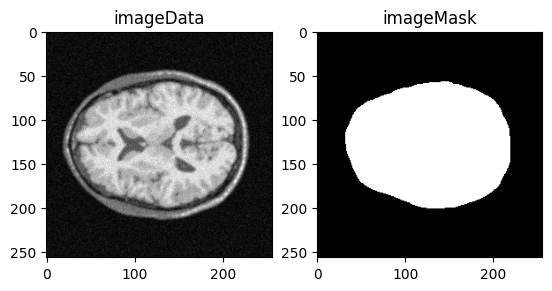

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray')
plt.title('imageData')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('imageMask')

(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


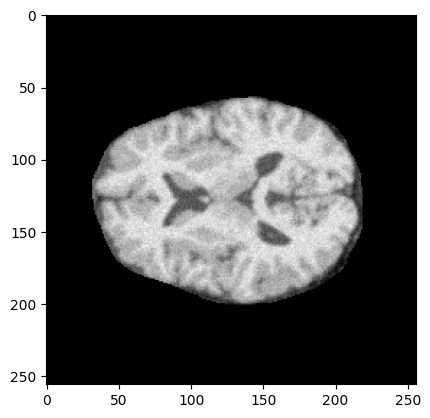

In [9]:
# Multiplying each pixel with the mask to remove the part outside the mask
brainData = data * mask
print(brainData.shape)
plt.imshow(brainData, cmap='gray')
print(brainData)